# Classificação morfológica de galáxias

In [1]:
from string import Template
from kaggle import api as kaggle_api
from zipfile import ZipFile
from os import path, mkdir
import pandas as pd
from shutil import copy
import matplotlib.pyplot as plt
import numpy as np

### Download do dataset

In [2]:
competition = 'galaxy-zoo-the-galaxy-challenge'
data_path = '../data/downloads/'

kaggle_api.authenticate()

kaggle_api.competition_download_file(file_name='images_training_rev1', competition=competition, path=data_path)
kaggle_api.competition_download_file(file_name='training_solutions_rev1', competition=competition, path=data_path)

images_training_rev1.zip: Skipping, found more recently modified local copy (use --force to force download)
training_solutions_rev1.zip: Skipping, found more recently modified local copy (use --force to force download)


### Unzip do dataset

In [3]:
if path.isdir('../data/downloads/images_training_rev1') is False:
    ZipFile('../data/downloads/images_training_rev1.zip').extractall('../data/downloads')

if path.isfile('../data/downloads/training_solutions_rev1.csv') is False:
    ZipFile('../data/downloads/training_solutions_rev1.zip').extract('training_solutions_rev1.csv', '../data/downloads')

 
### Carregar dados das galáxias e ajustar DataFrames para filtrar

#### Separar galáxias por classe

 Para a classificação das galáxias, o dataset fornecido pelo galaxy challenge vem com 37 classes.
 
 Para reduzir a quantidade classes, filtramos as classes que desejamos e e copiamos cada classe par
 sua devida pasta. Usaremos imagens apenas com indices de respostas maiores de 90%.
- completely-rounded: Class7.1
- in-between: 7.2
- cigar-shaped: Class7.3
- on-edge: Class2.1
- spiral-barred: Class3.1 && Class4.1
- spiral: Class3.2 && Class4.1

In [4]:
original_training_data = pd.read_csv('../data/downloads/training_solutions_rev1.csv')

# Pandas coloca o galaxyID como float, convertemos novamente para string.
original_training_data['GalaxyID'] = original_training_data['GalaxyID'].astype(str)

columns_mapper = {
    'GalaxyID': 'GalaxyID',
    'Class7.1': 'completely_round',
    'Class7.2': 'in_between',
    'Class7.3': 'cigar_shaped',
    'Class2.1': 'on_edge',
    'Class4.1': 'has_signs_of_spiral',
    'Class3.1': 'spiral_barred',
    'Class3.2': 'spiral'
}
columns = list(columns_mapper.values())
training_df = original_training_data.rename(columns=columns_mapper)[columns]
training_df.head(10)

,GalaxyID,completely_round,in_between,cigar_shaped,on_edge,has_signs_of_spiral,spiral_barred,spiral
0,100008,0.201463,0.181684,0.000000,0.000000,0.418398,0.038452,0.578401
1,100023,0.000000,0.135082,0.191919,0.031178,0.591328,0.467370,0.165229
2,100053,0.000000,0.741864,0.023853,0.000000,0.000000,0.000000,0.177352
3,100078,0.408599,0.284778,0.000000,0.000000,0.189098,0.109493,0.129071
4,100090,0.494587,0.439252,0.000000,0.000000,0.000000,0.000000,0.000000
5,100122,0.066807,0.663691,0.008335,0.000000,0.000000,0.000000,0.238159
6,100123,0.388158,0.074334,0.000000,0.000000,0.000000,0.000000,0.456033
7,100128,0.482483,0.205300,0.000000,0.000000,0.000000,0.069098,0.219246
8,100134,0.010917,0.010917,0.000000,0.021751,0.546491,0.313077,0.642124
9,100143,0.000000,0.000000,0.269843,0.730157,0.000000,0.000000,0.000000


### Criar DataFrames para cada classe

In [5]:
# Filters
has_sign_of_spiral = training_df['has_signs_of_spiral'] >= 0.75 # filter

# DataFrames of each class
completely_round_df = training_df[training_df['completely_round'] >= 0.65]

in_between_df = training_df[training_df['in_between'] >= 0.65]
cigar_shaped_df = training_df[training_df['cigar_shaped'] >= 0.65]
on_edge_df = training_df[training_df['on_edge'] >= 0.75]
spiral_barred_df = training_df[(training_df['spiral_barred'] >= 0.75) & has_sign_of_spiral]
spiral_df = training_df[(training_df['spiral'] >= 0.75) & has_sign_of_spiral]

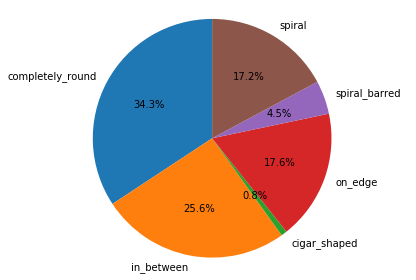

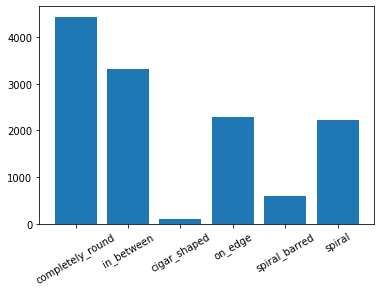

In [9]:
labels = ['completely_round', 'in_between', 'cigar_shaped', 'on_edge', 'spiral_barred', 'spiral']
sizes = [
    completely_round_df.shape[0],
    in_between_df.shape[0],
    cigar_shaped_df.shape[0],
    on_edge_df.shape[0],
    spiral_barred_df.shape[0],
    spiral_df.shape[0]
]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.show()

index = np.arange(len(labels))

plt.bar(index, sizes)

plt.xticks(index, labels, rotation=30)
plt.show()

### Copiar arquivos para as devidas pastas

In [39]:
if path.isdir('../data/training') is False:
    mkdir('../data/training')

def copy_images(df, dest):
    src_path = Template('../data/downloads/images_training_rev1/$name.jpg')
    dest_path = Template('../data/training/$folder/').substitute(folder=dest)

    if path.isdir(dest_path) is True:
        return

    mkdir(dest_path)
    for index, image in df.iterrows():
        copy(src_path.substitute(name=image['GalaxyID']), dest_path)

copy_images(completely_round_df, 'completely_round')
copy_images(in_between_df, 'in_between')
copy_images(cigar_shaped_df, 'cigar_shaped')
copy_images(on_edge_df, 'on_edge')
copy_images(spiral_barred_df, 'spiral_barred')
copy_images(spiral_df, 'spiral')